In [18]:
import pypsa
import matplotlib.pyplot as plt
import pandas as pd
import myUtils as utils
import seaborn as sns

tech = "warm"  #biogas,battery, biomass, ror, geothermal,transmission, warm, bev
rootPath = f"../../results/scenario/{tech}"
pathTail = "/networks/base_s_27_3H_3H_2045.nc"

nBase = pypsa.Network(f"../../results/scenario/base{pathTail}")
nMean = pypsa.Network(f"{rootPath}_mean/{pathTail}")
nGood = pypsa.Network(f"{rootPath}_good/{pathTail}")
nBest = pypsa.Network(f"{rootPath}_best/{pathTail}")

networks = {
  "Sehr Optimistisch": nBest,
  "Optimistisch": nGood,
  "Mittel": nMean,
  "Basis": nBase, 
}

INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores
INFO:pypsa.io:Imported network base_s_27_3H_3H_2045.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [19]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


def getDfValue (n):
  lists = [
    n.statistics.capex().sum() / 1e9,
    n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_grouper").sum() / 1e9,
     n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9, 
    # n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9,
    # n.statistics.opex(groupby="de_all_generator_grouper").sum() / 1e9,
  ]
  return lists

data = {
  'Name': [
    "CAPEX(inkl. Nachbarländer)",
    "CAPEX",
    "investierte CAPEX",
    "OPEX",

    "Strom CAPEX",
    # "Strom Opex"
  ],
  # 'Unit': [
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR'
  # ],
  'Base': getDfValue(nBase),
  'Mittel': getDfValue(nMean),
  'Opt.': getDfValue(nGood),
  'S. Opt.': getDfValue(nBest)
}
print(len(data['Name']), len(data['Name']), len(data['Base']))



df = pd.DataFrame(data).set_index('Name')

caepx_base = df.loc['CAPEX', 'Base']
caepx_changes = (df.loc['CAPEX', ['Mittel', 'Opt.', 'S. Opt.']] - caepx_base) / caepx_base * 100

elc_caepx_base = df.loc['Strom CAPEX', 'Base']
elc_caepx_changes = (df.loc['Strom CAPEX', ['Mittel', 'Opt.', 'S. Opt.']] - elc_caepx_base) / elc_caepx_base * 100
# df = df.drop(columns=['Base'])

df = df.T
table = utils.dataframe_to_table(df)
print(table)
print(caepx_changes)
print(elc_caepx_changes)

5 5 5
  [Base], [637,33], [74,93], [63,34], [5,49], [35,38],
  [Mittel], [626,02], [74,41], [62,83], [5,46], [35,03],
  [Opt.], [639,15], [73,62], [62,04], [5,23], [35,18],
  [S. Opt.], [592,66], [68,14], [56,55], [5,17], [34,42],
Mittel    -0.68488
Opt.      -1.73886
S. Opt.   -9.05925
Name: CAPEX, dtype: float64
Mittel    -0.97536
Opt.      -0.54223
S. Opt.   -2.70108
Name: Strom CAPEX, dtype: float64


In [11]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


def getDfValue (n):
  lists = [
    n.statistics.capex().sum() / 1e9,
    n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_grouper").sum() / 1e9,

    n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9,
    n.statistics.opex(groupby="de_all_generator_grouper").sum() / 1e9,
  ]
  return lists

data = {
  'Name': [
    "CAPEX(inkl. Nachbarländer)",
    "CAPEX",
    "investierte CAPEX",
    "OPEX",

    "Strom CAPEX",
    "Strom Opex"
  ],
  # 'Unit': [
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR'
  # ],
  'Base': getDfValue(nBase),
  'Mean': getDfValue(nMean),
  'Optimist': getDfValue(nGood),
  'Best': getDfValue(nBest)
}
print(len(data['Name']), len(data['Name']), len(data['Base']))



df = pd.DataFrame(data).set_index('Name')

caepx_base = df.loc['CAPEX', 'Base']
caepx_changes = (df.loc['CAPEX', ['Mean', 'Optimist', 'Best']] - caepx_base) / caepx_base * 100

elc_caepx_base = df.loc['Strom CAPEX', 'Base']
elc_caepx_changes = (df.loc['Strom CAPEX', ['Mean', 'Optimist', 'Best']] - elc_caepx_base) / elc_caepx_base * 100

table = utils.dataframe_to_table(df)
print(table)
print(caepx_changes)
print(elc_caepx_changes)

6 6 6
  [CAPEX(inkl. Nachbarländer)], [637,33], [634,52], [613,55], [558,31],
  [CAPEX], [74,93], [74,04], [72,00], [67,04],
  [investierte CAPEX], [63,34], [62,74], [60,70], [55,74],
  [OPEX], [5,49], [4,39], [4,52], [4,83],
  [Strom CAPEX], [35,38], [34,55], [33,36], [32,08],
  [Strom Opex], [0,13], [0,16], [0,15], [0,08],
Mean        -1.18405
Optimist    -3.90729
Best       -10.52554
Name: CAPEX, dtype: float64
Mean       -2.33417
Optimist   -5.68571
Best       -9.31452
Name: Strom CAPEX, dtype: float64


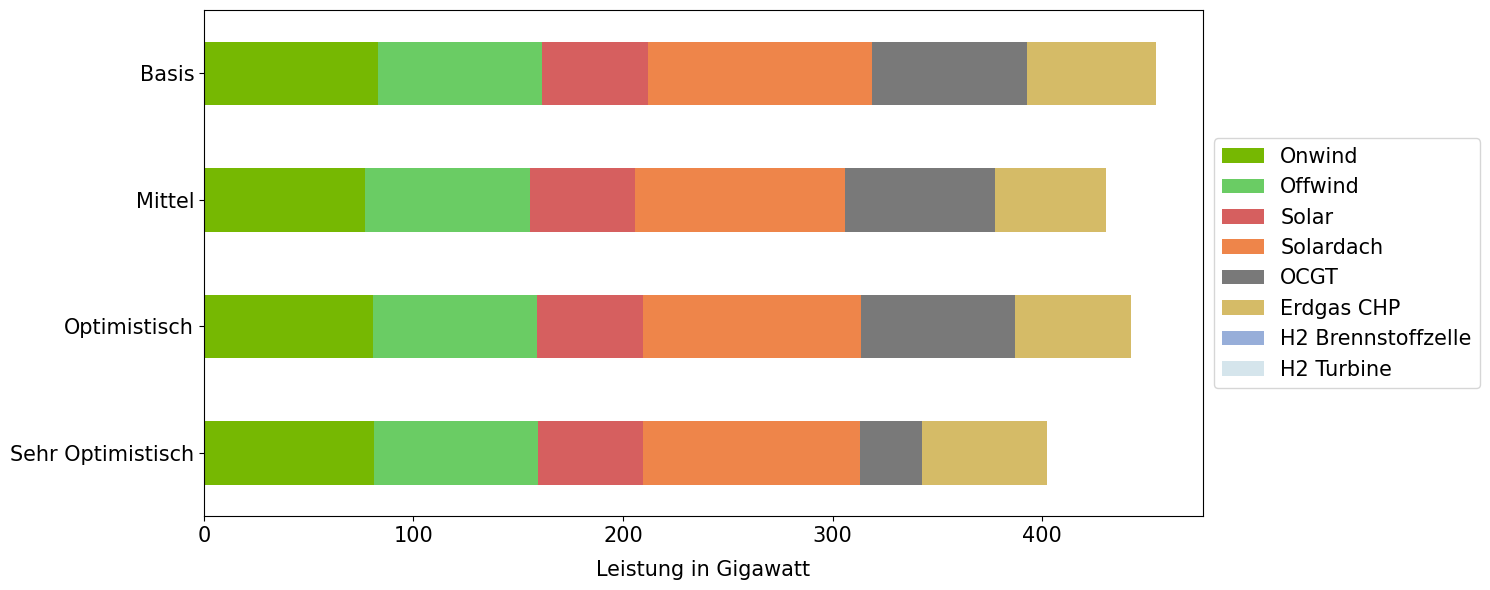

In [17]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted", 12)
%matplotlib inline

df = pd.DataFrame()

for key, n in networks.items():
  generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
  generators = generator_df.groupby('carrier').sum().p_nom_opt / 1e3
  g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
  generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt / 1e3

  battery_df = utils.getNByGroup(n, 'Link', utils.de_battery_discharger)
  battery_home_df = utils.getNByGroup(n, 'Link', utils.de_home_battery_discharger)

  V2G_df = utils.getNByGroup(n, 'Link', utils.de_v2g)

  h2_FC =utils.getNByGroup(n, 'Link', utils.de_h2_FC_grouper)
  h2_turbine =utils.getNByGroup(n, 'Link', utils.de_h2_turbine_grouper)

  ror = utils.getNByGroup(n, 'Generator', utils.de_ror_generator_grouper)

  h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
  h2s =  h2_df.groupby('carrier').sum().p_nom_opt / 1e3

  biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
  # print(biomass)
  s = pd.concat([generators, generatorLinks,h2s])
  s['Offwind'] = s['offwind-ac'] + s['offwind-dc'] + s['offwind-float']
  s['Solar'] = s['solar'] + s['solar-hsat']
  s['Onwind'] = s['onwind']
  

  s['Solardach'] = s['solar rooftop']
  s['Erdgas CHP'] = s['urban central CHP']
  s['Geothermie'] = s.get('geothermal organic rankine cycle', 0)
  s['Biomasse CHP'] = biomass.p_nom_opt.sum()  / 1e3
  s['Batterie'] = battery_df.p_nom_opt.sum() / 1e3 
  s['Heimbatterie'] =   battery_home_df.p_nom_opt.sum() / 1e3
  s['V2G'] = V2G_df.p_nom_opt.sum() / 1e3
  s['H2 Brennstoffzelle'] = h2_FC.p_nom_opt.sum() / 1e3
  s['H2 Turbine'] = h2_turbine.p_nom_opt.sum() / 1e3
  s['ROR'] = ror.p_nom_opt.sum() / 1e3
  # s['Gesamt'] = s.sum()
  
  s = s.reindex(['Onwind', 'Offwind', 'Solar', 'Solardach','OCGT', 'Erdgas CHP',
                #  'Geothermal', 'Biomasse CHP', 'ROR', 
                #  'Batterie', 'Heimbatterie'
                # , 'Biomasse CHP'
                'H2 Brennstoffzelle', 'H2 Turbine'
                # 'Geothermie',
                #  'V2G'
                # "ROR"
                 ])
  df[key] = s

# df = df[(df != 0).any(axis=1)]
df = df.fillna(0)


# print(utils.dataframe_to_table(df))

# print(df)
df_transposed = df.transpose()
# df_transposed = df_transposed[['Basis', 'Mittel', 'Optimistisch', 'Sehr Optimistisch']]

color = {
  'Onwind': '#76B802',
  'Offwind': '#6ACC64',
  'Solar': '#D65F5F',
  'Solardach': '#EE854A',
  'OCGT': '#797979',
  'Erdgas CHP': '#D5BB67',
  'Batterie': '#97AED9',
  'Heimbatterie': '#D5E5EC',
  'V2G': '#97AED9',
  'Biomasse CHP': '#97AED9',
  'Geothermie': '#97AED9',
  'H2 Brennstoffzelle': '#97AED9',
  'H2 Turbine': '#D5E5EC',
  "ROR": "#D5E5EC"
}

ax = df_transposed.plot(kind="barh", stacked=True,figsize=(15,6), color= color, fontsize=15)
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=15)

ax.set_xlabel('Leistung in Gigawatt',labelpad=10, fontsize=15)

plt.tight_layout()
plt.show()

In [7]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted", 12)
%matplotlib inline

df = pd.DataFrame()

for key, n in networks.items():
  print(key)
  generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
  generators = generator_df.groupby('carrier').sum().p_nom_opt / 1e3
  g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
  generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt / 1e3

  battery_df = utils.getNByGroup(n, 'Link', utils.de_battery_discharger)
  battery_home_df = utils.getNByGroup(n, 'Link', utils.de_home_battery_discharger)

  V2G_df = utils.getNByGroup(n, 'Link', utils.de_v2g)

  h2_FC =utils.getNByGroup(n, 'Link', utils.de_h2_FC_grouper)
  h2_turbine =utils.getNByGroup(n, 'Link', utils.de_h2_turbine_grouper)

  ror = utils.getNByGroup(n, 'Generator', utils.de_ror_generator_grouper)

  h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
  h2s =  h2_df.groupby('carrier').sum().p_nom_opt / 1e3

  biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
  # print(biomass)
  s = pd.concat([generators, generatorLinks,h2s])
  s['Offwind'] = s['offwind-ac'] + s['offwind-dc'] + s['offwind-float']
  s['Solar'] = s['solar'] + s['solar-hsat']
  s['Onwind'] = s['onwind']
  

  s['Solardach'] = s['solar rooftop']
  s['Erdgas CHP'] = s['urban central CHP']
  s['Geothermal'] = s.get('geothermal organic rankine cycle', 0)
  s['Biomasse CHP'] = biomass.p_nom_opt.sum()  / 1e3
  # s['Batterie'] = battery_df.p_nom_opt.sum() / 1e3 
  # s['Heimbatterie'] =   battery_home_df.p_nom_opt.sum() / 1e3
  # s['V2G'] = V2G_df.p_nom_opt.sum() / 1e3
  # s['H2 Brennstoffzelle'] = h2_FC.p_nom_opt.sum() / 1e3
  # s['H2 Turbine'] = h2_turbine.p_nom_opt.sum() / 1e3
  s['ROR'] = ror.p_nom_opt.sum() / 1e3
  s['Gesamt'] = s.sum()
  
  df[key] = s


# df = df[(df != 0).any(axis=1)]
df = df.fillna(0)

caepx_base = df.loc['Gesamt', 'Basis']
caepx_changes = (df.loc['Gesamt', ['Mittel', 'Optimistisch', 'Sehr Optimistisch']] - caepx_base) / caepx_base * 100

print(caepx_changes)

print(df)


Sehr Optimistisch
Optimistisch
Mittel
Basis
Mittel               -7.02821
Optimistisch        -11.17774
Sehr Optimistisch   -12.43081
Name: Gesamt, dtype: float64
                   Sehr Optimistisch  Optimistisch    Mittel     Basis
carrier                                                               
offwind-ac                  12.72175      12.72175  12.72175  12.72175
offwind-dc                  65.05452      65.05452  65.05452  65.05452
offwind-float                0.55251       0.55251   0.55251   0.55251
onwind                      71.58579      78.13532  81.05618  83.10055
solar                       50.28718      50.28718  50.28718  50.28718
solar rooftop               93.05176     100.25849 105.06803 107.32740
solar-hsat                   0.00012       0.00020   0.00021   0.00023
OCGT                         0.00014       0.00056  24.03897  73.80419
urban central CHP            0.00012       0.81730  17.40120  61.30232
H2 Fuel Cell                 8.05472       0.00007   0.0

In [5]:
# Installierte Kapazität  konventioneller Kraftwerke in GW  

import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)

plt.style.use('seaborn-v0_8-muted')
sns.color_palette("muted", 12)
%matplotlib inline

df = pd.DataFrame()

for key, n in networks.items():
  print(key)
  generator_df = utils.getNByGroup(n, 'Generator', utils.de_generator_grouper)
  generators = generator_df.groupby('carrier').sum().p_nom_opt / 1e3
  g_links_df = utils.getNByGroup(n, 'Link', utils.de_generator_grouper)
  generatorLinks = g_links_df.groupby('carrier').sum().p_nom_opt / 1e3

  battery_df = utils.getNByGroup(n, 'Link', utils.de_battery_discharger)
  battery_home_df = utils.getNByGroup(n, 'Link', utils.de_home_battery_discharger)

  V2G_df = utils.getNByGroup(n, 'Link', utils.de_v2g)

  h2_FC =utils.getNByGroup(n, 'Link', utils.de_h2_FC_grouper)
  h2_turbine =utils.getNByGroup(n, 'Link', utils.de_h2_turbine_grouper)

  ror = utils.getNByGroup(n, 'Generator', utils.de_ror_generator_grouper)

  h2_df = utils.getNByGroup(n, 'Link', utils.de_h2_dispatch_grouper)
  h2s =  h2_df.groupby('carrier').sum().p_nom_opt / 1e3

  biomass = utils.getNByGroup(n,'Link',utils.de_biomass_chp)
  # print(biomass)
  s = pd.concat([generators, generatorLinks,h2s])
  # s['Offwind'] = s['offwind-ac'] + s['offwind-dc'] + s['offwind-float']
  # s['Solar'] = s['solar'] + s['solar-hsat']
  # s['Onwind'] = s['onwind']
  

  # s['Solardach'] = s['solar rooftop']
  # s['Erdgas CHP'] = s['urban central CHP']
  # s['Geothermal'] = s.get('geothermal organic rankine cycle', 0)
  # s['Biomasse CHP'] = biomass.p_nom_opt.sum()  / 1e3
  # # s['Batterie'] = battery_df.p_nom_opt.sum() / 1e3 
  # # s['Heimbatterie'] =   battery_home_df.p_nom_opt.sum() / 1e3
  # # s['V2G'] = V2G_df.p_nom_opt.sum() / 1e3
  # s['H2 Brennstoffzelle'] = h2_FC.p_nom_opt.sum() / 1e3
  # s['H2 Turbine'] = h2_turbine.p_nom_opt.sum() / 1e3
  # s['ROR'] = ror.p_nom_opt.sum() / 1e3
  # s['Gesamt'] = s.sum()
  s['co2'] =  s['urban central CHP'] + s['OCGT']
  
  df[key] = s


# df = df[(df != 0).any(axis=1)]
df = df.fillna(0)

caepx_base = df.loc['co2', 'Basis']
caepx_changes = (df.loc['co2', ['Mittel', 'Optimistisch', 'Sehr Optimistisch']] - caepx_base) / caepx_base * 100

print(caepx_changes)

print(df)


Sehr Optimistisch
Optimistisch
Mittel
Basis
Mittel              -69.32777
Optimistisch        -99.39465
Sehr Optimistisch   -99.99981
Name: co2, dtype: float64
                   Sehr Optimistisch  Optimistisch    Mittel     Basis
carrier                                                               
offwind-ac                  12.72175      12.72175  12.72175  12.72175
offwind-dc                  65.05452      65.05452  65.05452  65.05452
offwind-float                0.55251       0.55251   0.55251   0.55251
onwind                      71.58579      78.13532  81.05618  83.10055
solar                       50.28718      50.28718  50.28718  50.28718
solar rooftop               93.05176     100.25849 105.06803 107.32740
solar-hsat                   0.00012       0.00020   0.00021   0.00023
OCGT                         0.00014       0.00056  24.03897  73.80419
urban central CHP            0.00012       0.81730  17.40120  61.30232
H2 Fuel Cell                 8.05472       0.00007   0.0000

In [250]:
import pandas as pd
import myUtils as utils
import importlib
importlib.reload(utils)


def getDfValue (n):
  lists = [
    # n.statistics.capex().sum() / 1e9,
    # n.statistics.capex(groupby="de_grouper").sum() / 1e9,
    # n.statistics.expanded_capex(groupby="de_grouper").sum() / 1e9,
    # n.statistics.opex(groupby="de_grouper").sum() / 1e9,
   n.statistics.capex(groupby="de_grouper").sum() / 1e9 +  n.statistics.opex(groupby="de_grouper").sum() / 1e9, 
    # n.statistics.capex(groupby="de_all_generator_grouper").sum() / 1e9,
    # n.statistics.opex(groupby="de_all_generator_grouper").sum() / 1e9,
  ]
  return lists

data = {
  'Name': [
   
    "G",
    # "Strom Opex"
  ],
  # 'Unit': [
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR',
  #   'Mrd.EUR'
  # ],
  'Base': getDfValue(nBase),
  'Mittel': getDfValue(nMean),
  'Opt.': getDfValue(nGood),
  'S. Opt.': getDfValue(nBest)
}
print(len(data['Name']), len(data['Name']), len(data['Base']))



df = pd.DataFrame(data).set_index('Name')

caepx_base = df.loc['G', 'Base']
caepx_changes = (df.loc['G', ['Mittel', 'Opt.', 'S. Opt.']] - caepx_base) / caepx_base * 100

# elc_caepx_base = df.loc['Strom CAPEX', 'Base']
# elc_caepx_changes = (df.loc['Strom CAPEX', ['Mittel', 'Opt.', 'S. Opt.']] - elc_caepx_base) / elc_caepx_base * 100
# df = df.drop(columns=['Base'])

# df = df.T
# table = utils.dataframe_to_table(df)
# print(table)
# print(caepx_changes)
print(caepx_changes)

1 1 1
Mittel    -0.68266
Opt.      -1.95370
S. Opt.   -8.84295
Name: G, dtype: float64
